In [1]:
# Importing Libraries
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import ast

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)


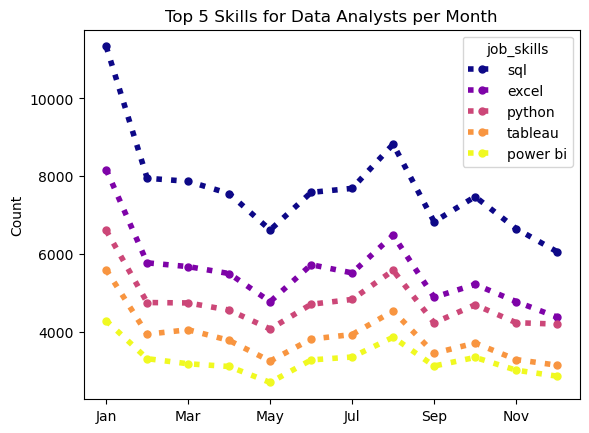

In [10]:
# Filter for Data Analyst Jobs
df_DA = df[df['job_title_short'] == 'Data Analyst'].copy()
# Create a new column for month number
df_DA['job_posted_month_no'] = df_DA['job_posted_date'].dt.month

#Explode the job_skills column and pivot
df_DA_explode = df_DA.explode('job_skills')
df_DA_pivot = df_DA_explode.pivot_table(index='job_posted_month_no', columns='job_skills', aggfunc='size', fill_value=0)

# Sort the skills by count
df_DA_pivot.loc['Total'] = df_DA_pivot.sum()
df_DA_pivot = df_DA_pivot[df_DA_pivot.loc['Total'].sort_values(ascending=False).index]
df_DA_pivot = df_DA_pivot.drop('Total')

# Use Month names for plotting
df_DA_pivot = df_DA_pivot.reset_index()
df_DA_pivot['job_posted_month'] = df_DA_pivot['job_posted_month_no'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
df_DA_pivot = df_DA_pivot.set_index('job_posted_month')
df_DA_pivot = df_DA_pivot.drop(columns='job_posted_month_no')

# Top 5 Skills and customising the plot
df_DA_pivot.iloc[:, :5].plot(
    kind='line',
    linewidth=4,
    linestyle=':',
    colormap='plasma',
    marker='o',
    markersize= 5)
plt.title('Top 5 Skills for Data Analysts per Month')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

In [11]:
# Customising the Scatter plot
df_DA_explode = df_DA.explode('job_skills')

# Calculate the average salary and count of job posted
skill_stats = df_DA_explode.groupby('job_skills').agg(
    median_salary = ('salary_year_avg', 'median'),
    skill_count = ('job_skills', 'count')
)

# Top 20 Skills
skill_count = 20
skill_stats = skill_stats.sort_values('skill_count', ascending=False).head(skill_count)
skill_stats

,median_salary,skill_count
job_skills,,
sql,92500.000000,92428
excel,84479.000000,66860
python,98500.000000,57190
tableau,95000.000000,46455
power bi,90000.000000,39380
r,92527.500000,29996
sas,90000.000000,27998
powerpoint,85000.000000,13822
word,80000.000000,13562


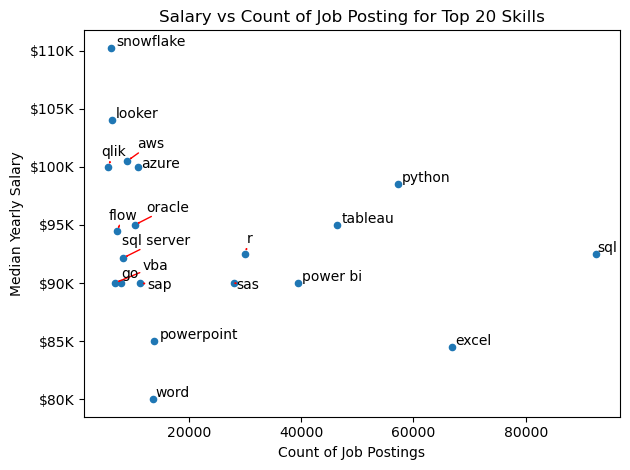

In [17]:
from adjustText import adjust_text

skill_stats.plot(kind='scatter', x='skill_count', y='median_salary')

texts = []
for i, txt in enumerate(skill_stats.index):
    texts.append(plt.text(skill_stats['skill_count'].iloc[i], skill_stats['median_salary'].iloc[i], txt))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='r', lw=1))

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K' ))
    
plt.title(f'Salary vs Count of Job Posting for Top {skill_count} Skills')
plt.xlabel('Count of Job Postings')
plt.ylabel('Median Yearly Salary')
plt.tight_layout()
plt.show()